## Image Registration Tutorial - Basics

First, we initialise the Python environment to make use of the developer version of SimpleITK.

In [2]:
import sys
sys.path.append('../src')
import imagedisplay

import numpy as np
import math as mt
import SimpleITK as sitk

import matplotlib.pyplot as plt
%matplotlib inline
from imagedisplay import myshow
from IPython.display import display, clear_output

### Comparing different (dis)similarity measures

The next cell is about a simple registration experiment for comparing different (dis)similarity measures. Here, we use the same 2D brain image for both the fixed and the moving image. We translate the moving image along the x-axis and record and plot the (dis)similarity values.

TASK: a) Try out different (dis)similarity measures, b) try out different interpolation methods, c) change the range of translations

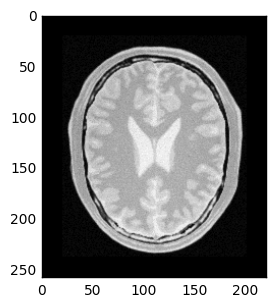

In [3]:
#load images
fixedInputFilename = "../data/BrainProtonDensitySliceBorder20.png"
fixedInput = sitk.ReadImage(fixedInputFilename)

#set fixed and moving to the same image
fixed = sitk.VectorIndexSelectionCast(fixedInput,0,sitk.sitkFloat32)
moving = fixed    

myshow(fixed)

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


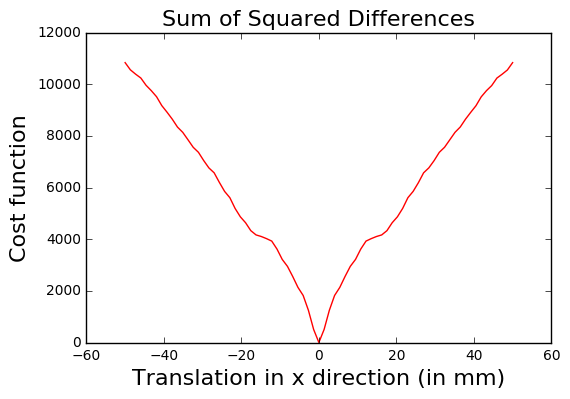

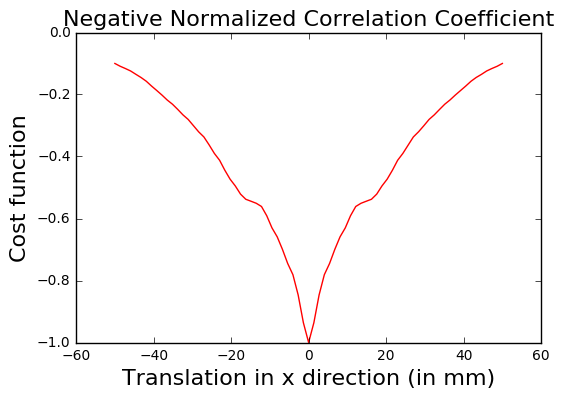

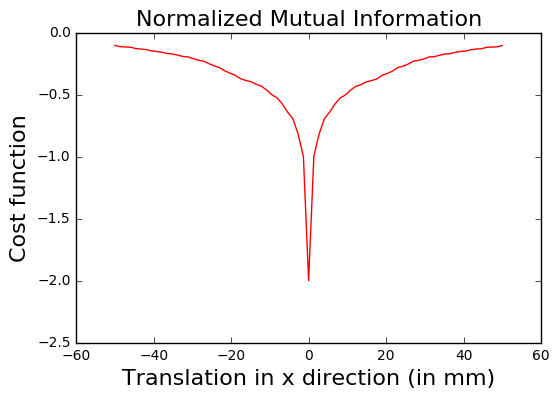

In [4]:
# the following defines a function that takes two images, an array with 1D translations, and a flag defining the (dis)similarity measure
def metric_calc_translation (fixed_img, moving_img, tx_array, metric='SSD'):
    
    # Define the registration object and properties 
    # (just to calculate the metric value - we are not going to perform optimization)
    R = sitk.ImageRegistrationMethod()    
    #R.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=60)
    R.SetOptimizerAsGradientDescent(learningRate=0.0, numberOfIterations=1)
    
    
    # Interpolation method
    # MAKE A SELECTION HERE
    
    # Nearest neighbor interpolation
    #R.SetInterpolator(sitk.sitkNearestNeighbor)

    # Linear interpolation
    R.SetInterpolator(sitk.sitkLinear)        

    if metric == 'SSD':
        R.SetMetricAsMeanSquares()
        title_str = 'Sum of Squared Differences'
    elif metric == 'CC':
        R.SetMetricAsCorrelation()
        title_str = 'Negative Normalized Correlation Coefficient'
    elif metric == 'NMI':
        R.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        title_str = 'Normalized Mutual Information'
    else:
        raise RuntimeError('undefined similarity metric')
        
    cost = []
    for tx in tx_array:
    
        # Create a transformation (translation in x-direction)
        t_input=sitk.Transform(fixed.GetDimension(), sitk.sitkTranslation)
        t_input.SetParameters( [tx,0] ); # t_input[0]=offset_x t_input[1]=offset_y

        # Run the cost function calculation
        R.SetInitialTransform(t_input)
        #R.SetTransform(t_input)
        R.Execute(fixed,moving)
        
        # Collect value
        cost.append(R.GetMetricValue())

    # Plot the metric values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title_str,fontsize=16)   

    ax.set_xlabel('Translation in x direction (in mm)',fontsize=16)
    ax.set_ylabel('Cost function',fontsize=16)
    ax.plot(tx_arr,cost,'r')
    fig.show()
      
        
# CHANGE CODE HERE: Try different a different translation range
tx_arr = np.linspace(-50.0, 50.0, num=75, endpoint=True)

# Run the experiment
metric_calc_translation (fixed,moving,tx_arr,'SSD')
metric_calc_translation (fixed,moving,tx_arr,'CC')
metric_calc_translation (fixed,moving,tx_arr,'NMI')

### Effect of Gaussian smoothing

Now we explore the effect of Gaussian smoothing on the (dis)similarity values.

TASK: a) try out different filter kernel sizes, b) try out differernt (dis)similarity measures

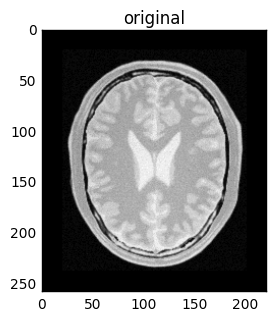

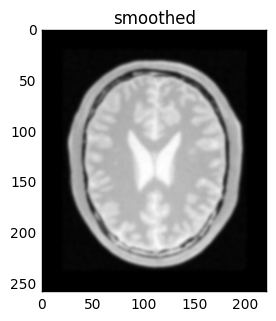

In [5]:
tx_arr = np.linspace(-15.0, 20.0, num=100, endpoint=True)

myshow(fixed,'original')

# Apply Gaussian smoothing to the fixed and the moving image
moving_smooth = sitk.DiscreteGaussian(moving, 2.0)
fixed_smooth = sitk.DiscreteGaussian(fixed, 2.0)

myshow(fixed_smooth, 'smoothed')

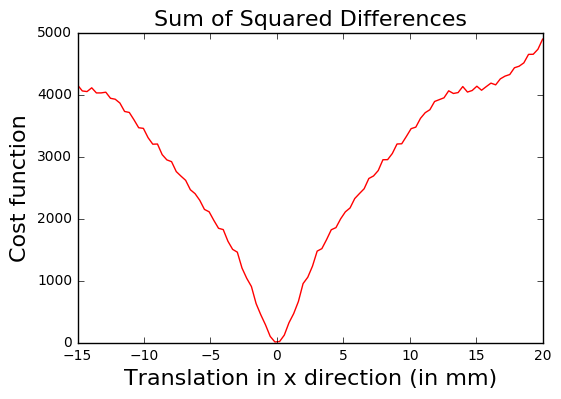

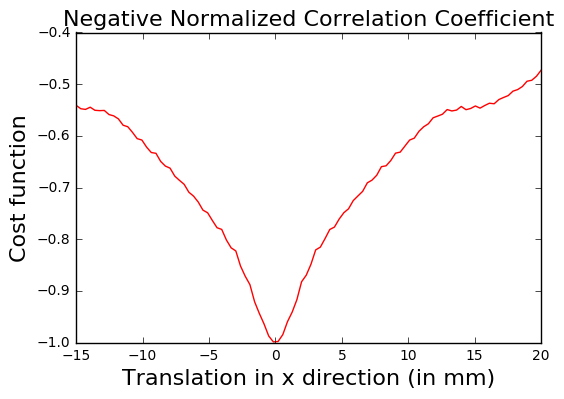

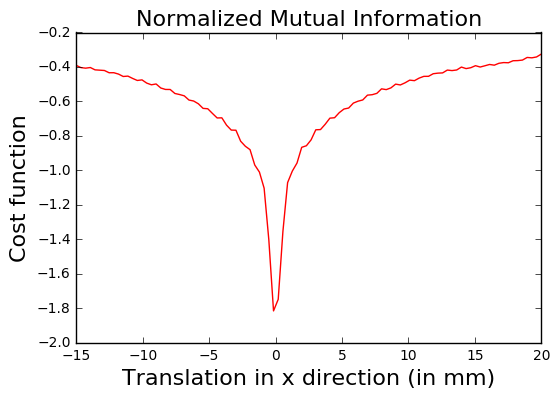

In [6]:
# Re-run the little translation experiments
metric_calc_translation (fixed_smooth,moving_smooth,tx_arr,metric='SSD')
metric_calc_translation (fixed_smooth,moving_smooth,tx_arr,metric='CC')
metric_calc_translation (fixed_smooth,moving_smooth,tx_arr,metric='NMI')

### Effect of Rotation

In the next cell, we repeat the earlier experiment, but this time the moving image is also rotated.

TASK: Explore how different rotations impact the (dis)similarity values.

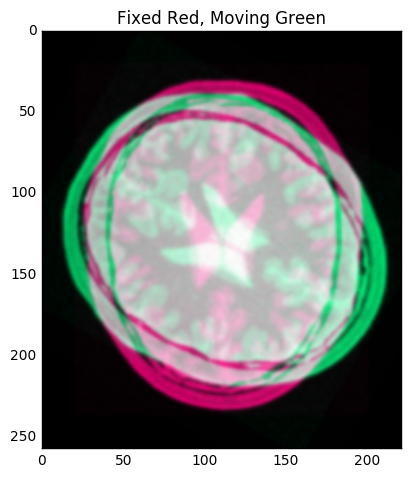

In [7]:
# CHANGE CODE HERE: Try different values for the rotation
angle = 3.14/3


# Define display function
def cmyshow(img1,img2,*args, **kw):
    simg1 = sitk.Cast(sitk.RescaleIntensity(img1), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(img2), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1/2.+simg2/2.)
    myshow(cimg,*args, **kw)

    
# Define the warping function
def warpmyimage(reference,img_source,transformation):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0.0)
    resampler.SetTransform(transformation)
    moving = resampler.Execute(img_source)
    return moving


# Read the image again
fixedInputFilename = "../data/BrainProtonDensitySliceBorder20.png"
fixedInput = sitk.ReadImage(fixedInputFilename)
fixed = sitk.VectorIndexSelectionCast(fixedInput,0,sitk.sitkFloat32)

# Smooth the input image
fixed = sitk.DiscreteGaussian(fixed, 1.0)

# Move the image center to origin - the rotation will be performed around the point (0,0)
spacing = fixed.GetSpacing();dimension = fixed.GetSize();  
fixed.SetOrigin([-1*spacing[0]*dimension[0]//2,-1*spacing[1]*dimension[1]//2])

# Transformation object for rotation (http://www.itk.org/Doxygen/html/classitk_1_1Euler2DTransform.html)
# Get the parameters that uniquely define the transform This is typically used by optimizers. There are 3 parameters. The first one represents the angle or rotation in radians and the last two represents the translation. The center of rotation is fixed.
t_input=sitk.Transform(fixed.GetDimension(), sitk.sitkEuler)
p = list(t_input.GetParameters()); p[0] = angle; t_input.SetParameters(p)

# Resample the moving image based on this transformation
moving = warpmyimage(fixed,fixed,t_input)
cmyshow(fixed,moving, title="Fixed Red, Moving Green", dpi = 50)

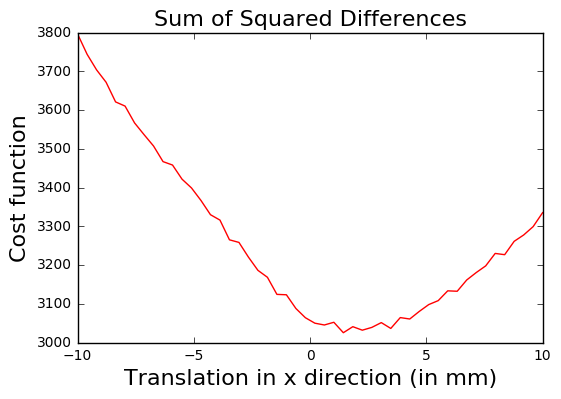

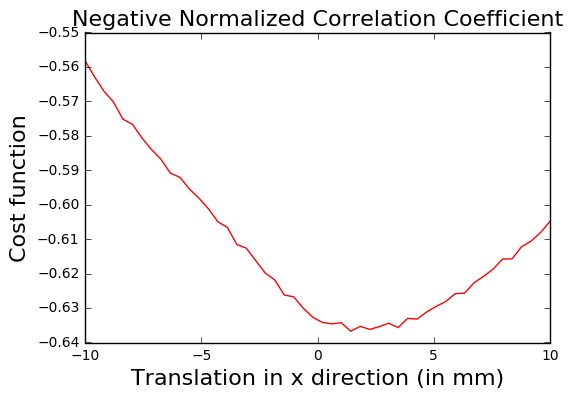

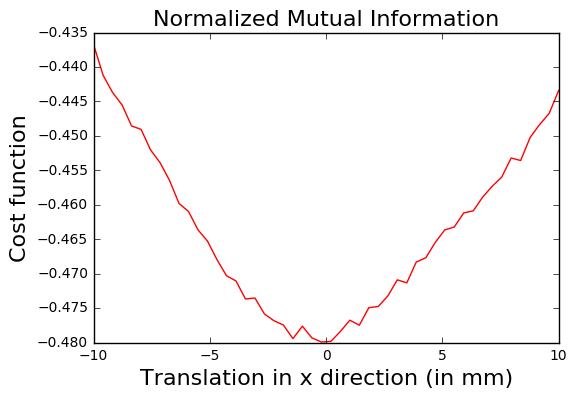

In [8]:
# Run the (dis)similarity evaluation for a range of translations
tx_arr = np.linspace(-10.0, 10.0, num=50, endpoint=True)
metric_calc_translation (fixed,moving,tx_arr,metric='SSD')
metric_calc_translation (fixed,moving,tx_arr,metric='CC')
metric_calc_translation (fixed,moving,tx_arr,metric='NMI')

### Using an optimisation method

The parameter space has 3 dimensions (1 rotation & 2 translations).
To obtain the optimal transformation, it is possible to perform a greedy search which is computationally very expensive. Rather than doing this, in this cell we will try to optimize the cost function with gradient descent algorithm.

TASK: Try out different (dis)similarity measures

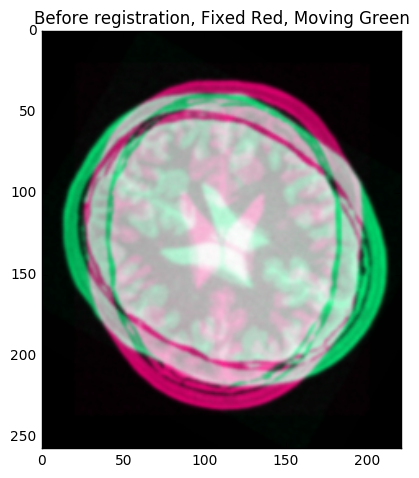

In [9]:
cmyshow(fixed,moving,title="Before registration, Fixed Red, Moving Green", dpi = 50)

0 = -0.479028987546 : (-1.8201909665599326e-06, 1.3994593492945078e-06, -2.1101907476383208e-06)
1 = -0.479030214683 : (-3.640286354261688e-06, 2.7994969160191526e-06, -4.221381677414939e-06)
2 = -0.479031440756 : (-5.4602854643238485e-06, 4.200112017367661e-06, -6.33357684434826e-06)
3 = -0.479032667659 : (-7.280189923756694e-06, 5.601304603659538e-06, -8.446772562191114e-06)
4 = -0.479033893321 : (-9.099997099469962e-06, 7.0030716820318394e-06, -1.0560964101707758e-05)
5 = -0.479035119792 : (-1.0919708621565005e-05, 8.40541816217544e-06, -1.267615753646912e-05)
6 = -0.479036342888 : (-1.2739323592079742e-05, 9.808339507665674e-06, -1.4792357771927827e-05)
7 = -0.479037567647 : (-1.4558842850413097e-05, 1.121183362685719e-05, -1.6909553984035068e-05)
8 = -0.479038792923 : (-1.6378264044497517e-05, 1.261589815861333e-05, -1.9027753199147325e-05)
9 = -0.47904001695 : (-1.819758966839289e-05, 1.4020537387105351e-05, -2.1146949177704293e-05)
10 = -0.479041239923 : (-2.0016818018500484e-05

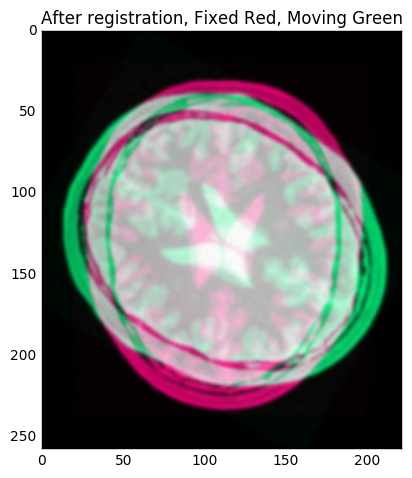

In [10]:
# Setting up the registration
R = sitk.ImageRegistrationMethod()

# (Dis)similarity measure
# MAKE A SELECTION HERE

# SSD
#R.SetMetricAsMeanSquares()

# CC
#R.SetMetricAsCorrelation()

# NMI
R.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

R.SetOptimizerAsGradientDescent(learningRate=0.001, numberOfIterations=500)
R.SetOptimizerScales([100.0, 1.0, 1.0])
R.SetInitialTransform(sitk.Transform(fixed.GetDimension(), sitk.sitkEuler))
R.SetInterpolator(sitk.sitkLinear)

def command_iteration(method) :
    print("{0} = {1} : {2}".format(method.GetOptimizerIteration(),method.GetMetricValue(),method.GetOptimizerPosition()));
    sys.stdout.flush();

def command_end(R):
    print("-------")
    print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
    print(" Iteration: {0}".format(R.GetOptimizerIteration()))
    print(" Metric value: {0}".format(R.GetMetricValue()))
    sys.stdout.flush();
    
R.RemoveAllCommands()
R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )
R.AddCommand( sitk.sitkEndEvent, lambda: command_end(R) )

t_output=R.Execute(fixed,moving)
warped_image = warpmyimage(fixed,moving,t_output)


cmyshow(fixed,warped_image, title="After registration, Fixed Red, Moving Green", dpi = 50)

### Plotting the progress of optimisation

In the next two cells, we are plotting the progress of the (dis)similarity measure during optimisation with two different methods. The first one is using Gradient Descent, the second one is using the Nealder-Mead/Downhill Simplex optimiser (http://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method).

TASK: Try to explain the two differernt curves

#### Gradient Descent

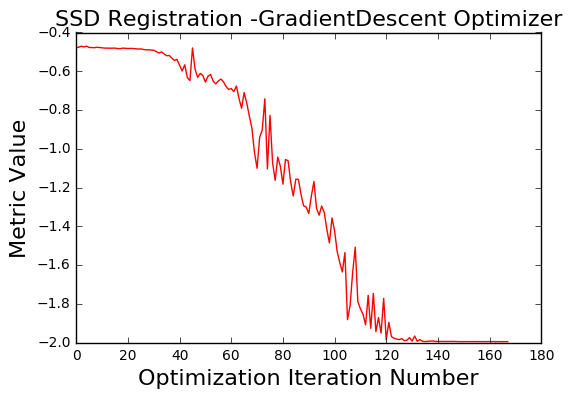

<SimpleITK.SimpleITK.Transform; proxy of <Swig Object of type 'itk::simple::Transform *' at 0x7fb825026a80> >

In [12]:
def command_plot_value_start(method,title):
    global x, ax, f
    x = []
    f, ax = plt.subplots()
    ax.set_title(title,fontsize=16)   
    ax.set_xlabel('Optimization Iteration Number',fontsize=16)
    ax.set_ylabel('Metric Value',fontsize=16)

def command_plot_value_end(method):
    global x, ax
    del x
    del ax
    plt.close()

def command_plot_value(method):
    global x, ax, f
    v = method.GetMetricValue()
    x.append(v)
    if( len(ax.lines) > 0 ):
        ax.lines.pop(0)
    ax.plot(x,'r')
    display(f)
    
titleSSD='SSD Registration -GradientDescent Optimizer'
R.RemoveAllCommands()
R.AddCommand( sitk.sitkIterationEvent, lambda:  clear_output() )
R.AddCommand( sitk.sitkStartEvent, lambda: command_plot_value_start(R,titleSSD) )
R.AddCommand( sitk.sitkEndEvent, lambda: command_plot_value_end(R) )
R.AddCommand( sitk.sitkIterationEvent, lambda: command_plot_value(R) )

R.SetInitialTransform(sitk.Transform(fixed.GetDimension(), sitk.sitkEuler))

R.Execute(fixed,moving)

#### Downhill Simplex

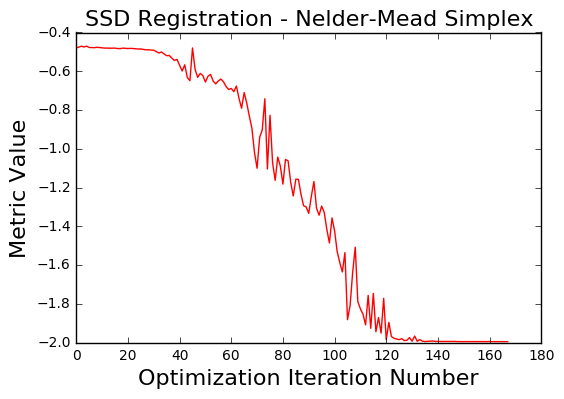

<SimpleITK.SimpleITK.Transform; proxy of <Swig Object of type 'itk::simple::Transform *' at 0x7fb825026c30> >

In [13]:
titleNelderMead='SSD Registration - Nelder-Mead Simplex'
R.RemoveAllCommands()
R.AddCommand( sitk.sitkIterationEvent, lambda:  clear_output() )
R.AddCommand( sitk.sitkStartEvent, lambda: command_plot_value_start(R,titleNelderMead) )
R.AddCommand( sitk.sitkEndEvent, lambda: command_plot_value_end(R) )
R.AddCommand( sitk.sitkIterationEvent, lambda: command_plot_value(R) )

R.SetInitialTransform(sitk.Transform(fixed.GetDimension(), sitk.sitkEuler))
R.SetOptimizerAsAmoeba(simplexDelta=3, numberOfIterations=500, parametersConvergenceTolerance=0.01,functionConvergenceTolerance=0.01); 

R.Execute(fixed,moving)